* 预处理方案
    - 原始图片缩放至 299×299
    - 左右旋转 20°
    - 向下平移 0.2
    - 水平翻转
    - 在水平翻转基础上左右旋转 20°
    - 向下平移 0.2
* 现在需要将图片和 Label 读入内存
    * 预先切分训练/验证集
* 训练 2 个 epoch
    * 第一个 epoch 的 lr = 0.001
    * 第二个 epoch lr 缩小 50 倍, lr = 0.00002
* 先不对验证集进行预处理, 测试这样预处理效果如何
* 再对验证集进行预处理, 得到每张图片 8 个不同的预测结果, 在做加权平均, 作为该图片的真实预测结果
    * 对测试集做数据预处理

In [2]:
import os
import cv2
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import itertools

from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix


warnings.filterwarnings('ignore')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## 导入数据

In [20]:
import os

def mkdir_if_not_exist(path):
    if not os.path.exists(os.path.join(*path)):
        os.makedirs(os.path.join(*path))

mkdir_if_not_exist(['./data/preprocessing'])

In [21]:
df_train = pd.read_csv('./data/train/Annotations/label.csv')
df_train.columns = ['image_id', 'class', 'label']
df_train.head()

,image_id,class,label
0,Images/collar_design_labels/0ef580b4deabcd9fa4...,collar_design_labels,ynnnn
1,Images/collar_design_labels/87ccc33937821a97ad...,collar_design_labels,nnynn
2,Images/collar_design_labels/26caac7d1f1b36fb9d...,collar_design_labels,ynnnn
3,Images/collar_design_labels/396ab4e7cbc6798100...,collar_design_labels,nynnn
4,Images/collar_design_labels/fc4a679c2bf209de13...,collar_design_labels,ynnnn


In [22]:
classes = ['collar_design_labels', 'neckline_design_labels', 'skirt_length_labels',
          'sleeve_length_labels', 'neck_design_labels', 'coat_length_labels', 'lapel_design_labels',
          'pant_length_labels']

## 加载数据

In [23]:
cur_class = classes[0]
df_load = df_train[(df_train['class'] == cur_class)].copy()
df_load.reset_index(inplace=True)
del df_load['index']

print('{0}: {1}'.format(cur_class, len(df_load)))
df_load.head()

collar_design_labels: 9058


,image_id,class,label
0,Images/collar_design_labels/0ef580b4deabcd9fa4...,collar_design_labels,ynnnn
1,Images/collar_design_labels/87ccc33937821a97ad...,collar_design_labels,nnynn
2,Images/collar_design_labels/26caac7d1f1b36fb9d...,collar_design_labels,ynnnn
3,Images/collar_design_labels/396ab4e7cbc6798100...,collar_design_labels,nynnn
4,Images/collar_design_labels/fc4a679c2bf209de13...,collar_design_labels,ynnnn


In [24]:
n_ration=0.9
valid_data=df_load[int(n_ration*len(df_load)):]
df_load=df_load[:int(n_ration*len(df_load))]

In [9]:
mkdir_if_not_exist(['./data/preprocessing/Images/{}/'.format(cur_class)])

## 数据预处理

In [8]:
rootdir = './data/train/Images/{}'.format(cur_class)  # 指明被遍历的文件夹
m = 0
outdir = './data/preprocessing/Images/{}/'.format(cur_class)

for parent, dirnames, filenames in os.walk(rootdir):
    for filename in filenames:
        currentPath = os.path.join(parent, filename)
 
        img = cv2.imread(currentPath)
        dst0 = cv2.resize(img, (299, 299)) # resize 到 299×299
        rows,cols,channel = dst0.shape

        # 顺逆时针旋转 20°
        M1 = cv2.getRotationMatrix2D((cols/2,rows/2),20,1) 
        M2 = cv2.getRotationMatrix2D((cols/2,rows/2),-20,1) 
        dst1 = cv2.warpAffine(dst0,M1,(cols,rows))
        dst2 = cv2.warpAffine(dst0,M2,(cols,rows))
        
        # 向下平移 0.2
        M3 = np.float32([[1,0,0],[0,1,int(cols*0.2)]])
        dst3 = cv2.warpAffine(dst0,M3,(cols,rows))
        
        # 水平翻转
        dst4 = cv2.flip(dst0, 1)
        
        # 对翻转后图片, 左右旋转 20°
        M4 = cv2.getRotationMatrix2D((cols/2,rows/2),20,1)
        M5 = cv2.getRotationMatrix2D((cols/2,rows/2),-20,1)
        dst5 = cv2.warpAffine(dst4,M4,(cols,rows))
        dst6 = cv2.warpAffine(dst4,M5,(cols,rows))
        
        # 翻转后向下平移 0.2
        M6 = np.float32([[1,0,0],[0,1,int(cols*0.2)]])
        dst7 = cv2.warpAffine(dst4,M6,(cols,rows))
        
        cv2.imwrite(outdir + filename + "-0.jpg", dst0)
        cv2.imwrite(outdir + filename + "-1.jpg", dst1)
        cv2.imwrite(outdir + filename + "-2.jpg", dst2)
        cv2.imwrite(outdir + filename + "-3.jpg", dst3)
        cv2.imwrite(outdir + filename + "-4.jpg", dst4)
        cv2.imwrite(outdir + filename + "-5.jpg", dst5)
        cv2.imwrite(outdir + filename + "-6.jpg", dst6)
        cv2.imwrite(outdir + filename + "-7.jpg", dst7)
        m += 1
        if m%100 == 0:
            print('{} images have preprocessed.'.format(m))

100 images have preprocessed.
200 images have preprocessed.
300 images have preprocessed.
400 images have preprocessed.
500 images have preprocessed.
600 images have preprocessed.
700 images have preprocessed.
800 images have preprocessed.
900 images have preprocessed.
1000 images have preprocessed.
1100 images have preprocessed.
1200 images have preprocessed.
1300 images have preprocessed.
1400 images have preprocessed.
1500 images have preprocessed.
1600 images have preprocessed.
1700 images have preprocessed.
1800 images have preprocessed.
1900 images have preprocessed.
2000 images have preprocessed.
2100 images have preprocessed.
2200 images have preprocessed.
2300 images have preprocessed.
2400 images have preprocessed.
2500 images have preprocessed.
2600 images have preprocessed.
2700 images have preprocessed.
2800 images have preprocessed.
2900 images have preprocessed.
3000 images have preprocessed.
3100 images have preprocessed.
3200 images have preprocessed.
3300 images have 

## 加载训练集

In [25]:
n = len(df_load)
n_class = len(df_load['label'][0])
width = 299 # 定义图片大小

X_train = np.zeros((n*8, width, width, 3), dtype=np.uint8)
y_train = np.zeros((n*8, n_class), dtype=np.uint8)

In [11]:
for i in tqdm(range(n)):
    tmp_label = df_load['label'][i]
#     if len(tmp_label) > n_class:
#         print(df_load['image_id'][i])
    for j in range(8):
        X_train[i*8+j] = cv2.resize(cv2.imread('./data/preprocessing/{0}'.format(df_load['image_id'][i] + "-%s.jpg"%j)), (width, width))
        y_train[i*8+j][tmp_label.find('y')] = 1

100%|██████████| 8152/8152 [01:38<00:00, 82.71it/s]


## 加载验证集

In [12]:
n_valid = len(valid_data)

X_valid = np.zeros((n_valid*8, width, width, 3), dtype=np.uint8)
y_valid = np.zeros((n_valid*8, n_class), dtype=np.uint8)

In [13]:
# 重置索引
valid_data = valid_data.reset_index(drop=True)

In [23]:
for i in tqdm(range(n_valid)):
    tmp_label = valid_data['label'][i]
#     if len(tmp_label) > n_class:
#         print(df_load['image_id'][i])
    for j in range(8):
        X_valid[i*8+j] = cv2.resize(cv2.imread('./data/preprocessing/{0}'.format(valid_data['image_id'][i] + "-%s.jpg"%j)), (width, width))
        y_valid[i*8+j][tmp_label.find('y')] = 1

100%|██████████| 906/906 [00:10<00:00, 86.97it/s]


In [15]:
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((65216, 299, 299, 3), (65216, 5), (7248, 299, 299, 3), (7248, 5))

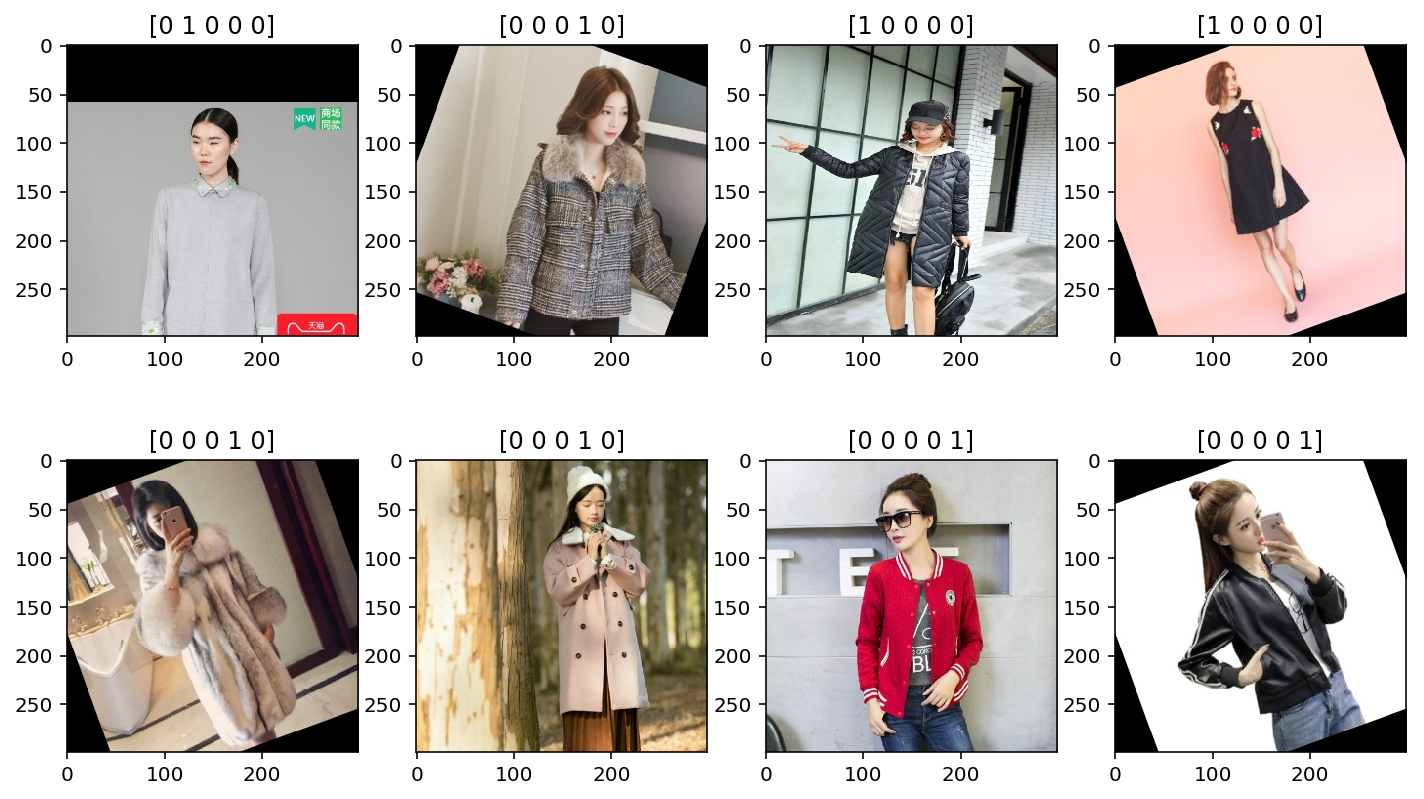

In [17]:
# 随机显示 8 张图片
plt.figure(figsize=(12, 7))
for i in range(8):
    random_index = random.randint(0, n-1)
    plt.subplot(2, 4, i+1)
    plt.imshow(X_train[random_index][:,:,::-1])
    plt.title(y_train[random_index])

## 建立模型

In [16]:
from keras.layers import *
from keras.models import *
from keras.callbacks import *
from keras.optimizers import *
from keras.applications import *
from keras.regularizers import *
from keras.applications.inception_v3 import preprocess_input

Using TensorFlow backend.


In [30]:
cnn_model = InceptionResNetV2(include_top=False, input_shape=(width, width, 3), weights='imagenet')
inputs = Input((width, width, 3))

x = inputs
x = Lambda(preprocess_input, name='preprocessing')(x)
x = cnn_model(x)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(n_class, activation='softmax', name='softmax')(x)

model = Model(inputs, x)

In [31]:
adam = Adam(lr=0.001)
prefix_cls = cur_class.split('_')[0]

In [21]:
model.compile(optimizer=adam,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [22]:
checkpointer = ModelCheckpoint(filepath='./models/{0}.best0509_InceptionResNetV2.h5'.format(prefix_cls), verbose=1, 
                               save_best_only=True)

try:
    h = model.fit(X_train, y_train, batch_size=32, epochs=1, 
                  callbacks=[EarlyStopping(patience=3), checkpointer], 
                  shuffle=True, 
                  validation_data=(X_valid, y_valid))
except KeyboardInterrupt:
    print('KeyboardInterrupt')

Train on 65216 samples, validate on 7248 samples
Epoch 1/2
65216/65216 [==============================] - 2219s 34ms/step - loss: 0.3390 - acc: 0.8704 - val_loss: 6.5494 - val_acc: 0.2823

Epoch 00001: val_loss improved from inf to 6.54945, saving model to ./models/collar.best0509_InceptionResNetV2.h5
Epoch 2/2
 9024/65216 [===>..........................] - ETA: 29:57 - loss: 0.0474 - acc: 0.9847

KeyboardInterrupt: 

In [28]:
model.load_weights('./models/{}.best0509_InceptionResNetV2.h5'.format(prefix_cls))

In [29]:
# 学习率减小 50 倍
adam = Adam(lr=0.00002)

model.compile(optimizer=adam,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [30]:
checkpointer = ModelCheckpoint(filepath='./models/{0}.best0509_InceptionResNetV2.h5'.format(prefix_cls), verbose=1, 
                               save_best_only=True)

try:
    h = model.fit(X_train, y_train, batch_size=32, epochs=1, 
                  callbacks=[EarlyStopping(patience=3), checkpointer], 
                  shuffle=True, 
                  validation_data=(X_valid, y_valid))
except KeyboardInterrupt:
    print('KeyboardInterrupt')

Train on 65216 samples, validate on 7248 samples
Epoch 1/1
65216/65216 [==============================] - 2213s 34ms/step - loss: 0.0335 - acc: 0.9889 - val_loss: 0.6983 - val_acc: 0.8491

Epoch 00001: val_loss improved from inf to 0.69827, saving model to ./models/collar.best0509_InceptionResNetV2.h5


## 测试集数据预处理

In [10]:
mkdir_if_not_exist(['./data/test-preprocessing/Images/{}/'.format(cur_class)])

In [11]:
rootdir = './data/week-rank/Images/{}'.format(cur_class)  # 指明被遍历的文件夹
m = 0
outdir = './data/test-preprocessing/Images/{}/'.format(cur_class)

for parent, dirnames, filenames in os.walk(rootdir):
    for filename in filenames:
        currentPath = os.path.join(parent, filename)
 
        img = cv2.imread(currentPath)
        dst0 = cv2.resize(img, (299, 299)) # resize 到 299×299
        rows,cols,channel = dst0.shape

        # 顺逆时针旋转 20°
        M1 = cv2.getRotationMatrix2D((cols/2,rows/2),20,1) 
        M2 = cv2.getRotationMatrix2D((cols/2,rows/2),-20,1) 
        dst1 = cv2.warpAffine(dst0,M1,(cols,rows))
        dst2 = cv2.warpAffine(dst0,M2,(cols,rows))
        
        # 向下平移 0.2
        M3 = np.float32([[1,0,0],[0,1,int(cols*0.2)]])
        dst3 = cv2.warpAffine(dst0,M3,(cols,rows))
        
        # 水平翻转
        dst4 = cv2.flip(dst0, 1)
        
        # 对翻转后图片, 左右旋转 20°
        M4 = cv2.getRotationMatrix2D((cols/2,rows/2),20,1)
        M5 = cv2.getRotationMatrix2D((cols/2,rows/2),-20,1)
        dst5 = cv2.warpAffine(dst4,M4,(cols,rows))
        dst6 = cv2.warpAffine(dst4,M5,(cols,rows))
        
        # 翻转后向下平移 0.2
        M6 = np.float32([[1,0,0],[0,1,int(cols*0.2)]])
        dst7 = cv2.warpAffine(dst4,M6,(cols,rows))
        
        cv2.imwrite(outdir + filename + "-0.jpg", dst0)
        cv2.imwrite(outdir + filename + "-1.jpg", dst1)
        cv2.imwrite(outdir + filename + "-2.jpg", dst2)
        cv2.imwrite(outdir + filename + "-3.jpg", dst3)
        cv2.imwrite(outdir + filename + "-4.jpg", dst4)
        cv2.imwrite(outdir + filename + "-5.jpg", dst5)
        cv2.imwrite(outdir + filename + "-6.jpg", dst6)
        cv2.imwrite(outdir + filename + "-7.jpg", dst7)
        m += 1
        if m%100 == 0:
            print('{} images have preprocessed.'.format(m))

100 images have preprocessed.
200 images have preprocessed.
300 images have preprocessed.
400 images have preprocessed.
500 images have preprocessed.
600 images have preprocessed.
700 images have preprocessed.
800 images have preprocessed.
900 images have preprocessed.
1000 images have preprocessed.
1100 images have preprocessed.
1200 images have preprocessed.
1300 images have preprocessed.
1400 images have preprocessed.
1500 images have preprocessed.


## 预处理图片进行全部预测

In [27]:
df_test = pd.read_csv('./data/week-rank/Tests/question.csv', header=None)
df_test.columns = ['image_id', 'class', 'x']
del df_test['x']
df_test.head()

,image_id,class
0,Images/collar_design_labels/1078bc9a4fa91aef69...,collar_design_labels
1,Images/collar_design_labels/272c5d069581efc94f...,collar_design_labels
2,Images/collar_design_labels/2e67922d82216cc756...,collar_design_labels
3,Images/collar_design_labels/d9726ceee17c7ee811...,collar_design_labels
4,Images/collar_design_labels/1b7de7f9def99a5aa6...,collar_design_labels


In [29]:
df_load2 = df_test[(df_test['class'] == cur_class)].copy()
df_load2.reset_index(inplace=True)
del df_load2['index']

print('{0}: {1}'.format(cur_class, len(df_load2)))
df_load2.head()

collar_design_labels: 1510


,image_id,class
0,Images/collar_design_labels/1078bc9a4fa91aef69...,collar_design_labels
1,Images/collar_design_labels/272c5d069581efc94f...,collar_design_labels
2,Images/collar_design_labels/2e67922d82216cc756...,collar_design_labels
3,Images/collar_design_labels/d9726ceee17c7ee811...,collar_design_labels
4,Images/collar_design_labels/1b7de7f9def99a5aa6...,collar_design_labels


In [14]:
n = len(df_load)
width = 299 # 定义图片大小
X_test = np.zeros((n*8, width, width, 3), dtype=np.uint8)

for i in tqdm(range(n)):
    for j in range(8):
        X_test[i*8+j] = cv2.resize(cv2.imread('./data/test-preprocessing/{0}'.format(df_load['image_id'][i] + "-%s.jpg"%j)), (width, width))

100%|██████████| 1510/1510 [00:15<00:00, 94.41it/s]


In [32]:
model.load_weights('./models/{}.best0509_InceptionResNetV2.h5'.format(prefix_cls))

In [33]:
test_np = model.predict(X_test, batch_size=256)

In [39]:
(test_np[i+j] + test_np[1])/2

array([9.99993384e-01, 1.87880289e-08, 6.60949718e-06, 1.01646425e-08,
       9.13017925e-11], dtype=float32)

In [49]:
# 取同一张图片不同预处理方式的平均值
result = []

for i, row in df_load2.iterrows():
    tmp_list = (test_np[i*8+0] + test_np[i*8+1] + test_np[i*8+2] + test_np[i*8+3] + test_np[i*8+4] + test_np[i*8+5] + test_np[i*8+6] + test_np[i*8+7])/8
    tmp_result = ''
    for tmp_ret in tmp_list:
        tmp_result += '{:.4f};'.format(tmp_ret)
        
    result.append(tmp_result[:-1])

df_load2['result'] = result
df_load2.head()

,image_id,class,result
0,Images/collar_design_labels/1078bc9a4fa91aef69...,collar_design_labels,0.9996;0.0000;0.0004;0.0000;0.0000
1,Images/collar_design_labels/272c5d069581efc94f...,collar_design_labels,0.0008;0.0002;0.0000;0.9990;0.0000
2,Images/collar_design_labels/2e67922d82216cc756...,collar_design_labels,0.9971;0.0028;0.0000;0.0000;0.0000
3,Images/collar_design_labels/d9726ceee17c7ee811...,collar_design_labels,0.1987;0.6363;0.1647;0.0003;0.0000
4,Images/collar_design_labels/1b7de7f9def99a5aa6...,collar_design_labels,0.0000;0.9990;0.0009;0.0000;0.0001


In [50]:
df_load2.to_csv('./result/{}_0510_InceptionResNetV2.csv'.format(prefix_cls), header=None, index=False)

## 预测结果

In [32]:
df_test = pd.read_csv('./data/week-rank/Tests/question.csv', header=None)
df_test.columns = ['image_id', 'class', 'x']
del df_test['x']
df_test.head()

,image_id,class
0,Images/collar_design_labels/1078bc9a4fa91aef69...,collar_design_labels
1,Images/collar_design_labels/272c5d069581efc94f...,collar_design_labels
2,Images/collar_design_labels/2e67922d82216cc756...,collar_design_labels
3,Images/collar_design_labels/d9726ceee17c7ee811...,collar_design_labels
4,Images/collar_design_labels/1b7de7f9def99a5aa6...,collar_design_labels


In [33]:
df_load = df_test[(df_test['class'] == cur_class)].copy()
df_load.reset_index(inplace=True)
del df_load['index']

print('{0}: {1}'.format(cur_class, len(df_load)))
df_load.head()

collar_design_labels: 1510


,image_id,class
0,Images/collar_design_labels/1078bc9a4fa91aef69...,collar_design_labels
1,Images/collar_design_labels/272c5d069581efc94f...,collar_design_labels
2,Images/collar_design_labels/2e67922d82216cc756...,collar_design_labels
3,Images/collar_design_labels/d9726ceee17c7ee811...,collar_design_labels
4,Images/collar_design_labels/1b7de7f9def99a5aa6...,collar_design_labels


In [39]:
n = len(df_load)
X_test = np.zeros((n, width, width, 3), dtype=np.uint8)

for i in tqdm(range(n)):
    X_test[i] = cv2.resize(cv2.imread('./data/week-rank/{0}'.format(df_load['image_id'][i])), (width, width))

100%|██████████| 1510/1510 [00:07<00:00, 205.40it/s]


In [36]:
'./data/week_rank/{0}'.format(df_load['image_id'][0])

'./data/week_rank/Images/collar_design_labels/1078bc9a4fa91aef69ddeb74e8404eba.jpg'

In [ ]:
# model.load_weights('./models/{}.best0509_InceptionResNetV2.h5'.format(prefix_cls))

In [40]:
test_np = model.predict(X_test, batch_size=256)

In [41]:
result = []

for i, row in df_load.iterrows():
    tmp_list = test_np[i]
    tmp_result = ''
    for tmp_ret in tmp_list:
        tmp_result += '{:.4f};'.format(tmp_ret)
        
    result.append(tmp_result[:-1])

df_load['result'] = result
df_load.head()

,image_id,class,result
0,Images/collar_design_labels/1078bc9a4fa91aef69...,collar_design_labels,1.0000;0.0000;0.0000;0.0000;0.0000
1,Images/collar_design_labels/272c5d069581efc94f...,collar_design_labels,0.0000;0.0001;0.0000;0.9999;0.0000
2,Images/collar_design_labels/2e67922d82216cc756...,collar_design_labels,0.9998;0.0001;0.0000;0.0000;0.0000
3,Images/collar_design_labels/d9726ceee17c7ee811...,collar_design_labels,0.0021;0.9960;0.0019;0.0000;0.0000
4,Images/collar_design_labels/1b7de7f9def99a5aa6...,collar_design_labels,0.0000;0.9999;0.0001;0.0000;0.0000


In [43]:
df_load.to_csv('./result/{}_0509_InceptionResNetV2.csv'.format(prefix_cls), header=None, index=False)